In [1]:
%matplotlib inline
import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
# Here the functions of the assembly process are given

def assemble_A(N, L, mu_faces):
    A = np.zeros((N, N))
    dy = L/(N-1)

    for i in range(1, N-1):
        A[i, i-1] = mu_faces[i-1]/dy**2
        A[i , i+1] = mu_faces[i]/dy**2
        A[i,i] = -(mu_faces[i-1] + mu_faces[i])/dy**2

    # Bot dirichlet bc  
    A[0,0] = 1
    A[0,1] = 1

    # Top dirichlet bc  
    A[-1,-1] = 1
    A[-1,-2] = 1

    return A

def assemble_b(N, L, p_grad):
    dy = L/(N-1)
    b = np.full(N, p_grad)

    # Bot dirichlet bc 
    b[0] = 0

    # Top dirichlet bc 
    b[-1] = 0
    
    return b

def init_mu_molecular_faces(N, mu):
    #create array of viscosity at gridpoints
    viscosity=np.ones(N)*mu
    mu_faces = (viscosity[:-1] + viscosity[1:])/2
    return mu_faces

def get_mixing_length(y, L):
    kappa = 0.41
    return kappa * y * (1 - y/L)

def get_mu_turbulent_faces(rho, u, N, L, y):
    dy = L/(N-1)
    du_dy = np.zeros(N)
    
    # Central differences to get du_dy
    du_dy[1:-1] = (u[2:] - u[:-2]) / (2*dy)
    du_dy[0] = (u[1]-u[0]) / dy
    du_dy[-1] = (u[-1]-u[-2]) / dy
    
    l_m = get_mixing_length(y, L)
    mu_turbulent = rho * l_m**2 * np.abs(du_dy)
    mu_turbulent_faces = (mu_turbulent[:-1] + mu_turbulent[1:])/2
    
    return mu_turbulent_faces

In [3]:
# Here the functions of the solve process are given

def solve_laminar(N, L, mu_molecular_faces, p_grad):
    A = assemble_A(N, L, mu_molecular_faces)
    b = assemble_b(N, L, p_grad)
    u = np.linalg.solve(A, b)
    return u

def solve_turbulent(N, L, mu_molecular_faces, rho, y, p_grad):
    u = solve_laminar(N, L, mu_molecular_faces, p_grad)
    
    err = 1
    while err > 1e-5:
        # Calculate the turbulent viscosity
        mu_turbulent_faces = get_mu_turbulent_faces(rho, u, N, L, y)
        mu_faces = mu_molecular_faces + mu_turbulent_faces
    
        # Calculate new velocity profile
        A = assemble_A(N, L, mu_faces)
        b = assemble_b(N, L, p_grad)
        u_new = np.linalg.solve(A, b)
        err = np.abs(np.mean(u-u_new))
        u = u_new
    return u

def solve_flowrate(Q_target, N, L, mu_molecular_faces, rho, y, p_grad_guess, tolerance = 1e-6, max_iter = 100):
    p_grad = p_grad_guess
    dy = L/(N-1)
    for _ in range(max_iter):
    
        u = solve_turbulent(N, L, mu_molecular_faces, rho, y, p_grad)
    
        # Compute flow rate
        q_simulated = np.sum(u) * dy
        Q_simulated = q_simulated * L
    
        rel_error = np.abs(Q_simulated - Q_target) / Q_target
        if rel_error < tolerance:
            break    
        # Update pressure gradient
        p_grad *= Q_target / Q_simulated
    
    return u, p_grad

In [4]:
# Set simulation parameters
p_grad = -2660 # Given pressure
Q_target = 0.0001 # Target for flow rate
p_grad_guess = -2660 # Initial guess for pressure

tolerance = 1e-6
max_iter = 100

N = 100
L = 3e-2
mu = 0.001
rho = 1060

k_wall = 1e-9 # Wall permeability
C0 = 3e-3 # Concentration of LDL
eta = 0.5 # fraction of LDL becoming plaque
h0 = 0 # initial thickness
rho_chol = 1100
MLDL = 2.5e3 # kg per mole
dt = 10*24*3600
t_final = 3600*24*365*50

L_aorta = 30e-2
pressure_conversion_factor = 0.0075

# Derived simulation parameters
mu_molecular_faces = init_mu_molecular_faces(N, mu)
y = np.linspace(0, L, N)

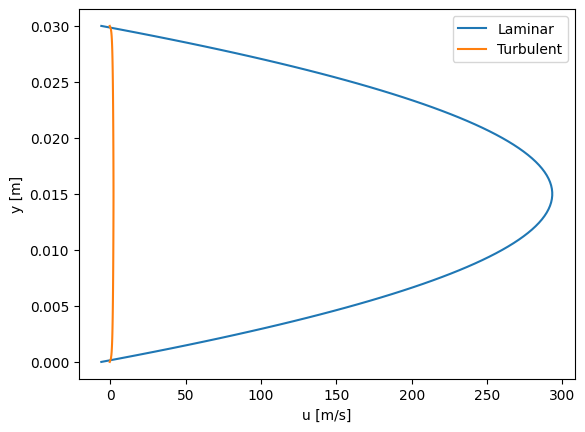

In [5]:
# Here we show the effect of turbulence on the velocity profile

# First we get a laminar profile
u = solve_laminar(N, L, mu_molecular_faces, p_grad)

plt.plot(u, y, label='Laminar')

# Then we get a turbulent profile
u = solve_turbulent(N, L, mu_molecular_faces, rho, y, p_grad)

plt.plot(u, y, label='Turbulent')
plt.legend()
plt.xlabel('u [m/s]')
plt.ylabel('y [m]')
plt.show()

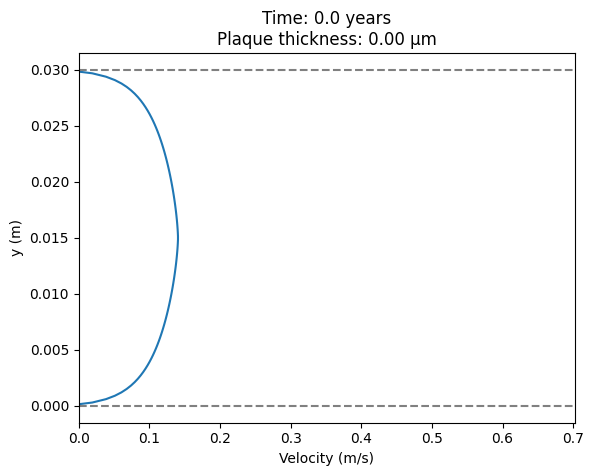

In [6]:
# Here we show diffusion of LDL into the wall

u, p_grad = solve_flowrate(Q_target, N, L, mu_molecular_faces, rho, y, p_grad_guess)

pressure_gradients = []

dh_dt = (eta * k_wall * C0 * MLDL) / rho_chol

times = np.arange(0, t_final + dt, dt)
h = h0 + dh_dt * times

fig, ax = plt.subplots()
line, =ax.plot(u, y)
ax.set_xlim(0, np.max(u)*5)
bottom_wall = ax.axhline(h[0], linestyle='--', color='gray')
top_wall = ax.axhline(L - h[0], linestyle='--', color='gray')
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('y (m)')
ax.set_title('Plaque Growth Over Time')

def update(frame):
    bottom_wall.set_ydata([h[frame], h[frame]])
    top_wall.set_ydata([L - h[frame], L - h[frame]])
    ax.set_title(f"Time: {times[frame]/(3600*24*356):.1f} years\nPlaque thickness: {1e6 * h[frame]:.2f} µm")
    
    # Get new velocity profile
    new_L = L - 2*h[frame]
    new_y = np.linspace(h[frame], L - h[frame], N)
    
    u, p_grad = solve_flowrate(Q_target, N, new_L, mu_molecular_faces, rho, new_y, p_grad_guess)
    pressure_gradients.append(p_grad)
        
    line.set_xdata(u)
    line.set_ydata(new_y)
    
    return line, bottom_wall, top_wall

skip = 10  # Use every 10th frame
ani = animation.FuncAnimation(fig, update, frames=range(0, len(times), skip), interval=40, blit=False)

HTML(ani.to_jshtml())

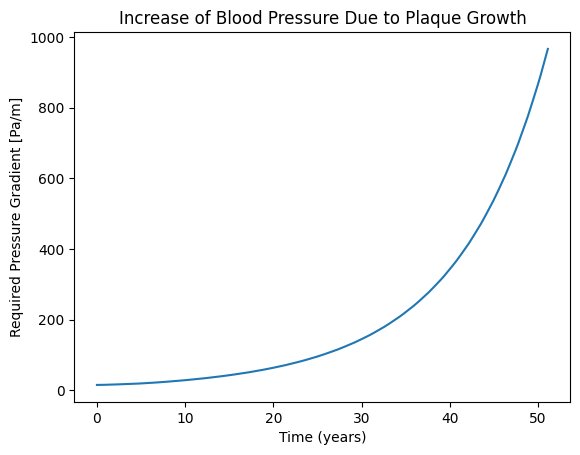

In [70]:
pressure_gradients = np.array(pressure_gradients)

plt.figure()
plt.plot(times[::skip] / (3600 * 24 * 356), np.abs(pressure_gradients)[:len(times[::skip])])
plt.xlabel("Time (years)")
plt.ylabel("Required Pressure Gradient [Pa/m]")
plt.title("Increase of Blood Pressure Due to Plaque Growth")
plt.show()

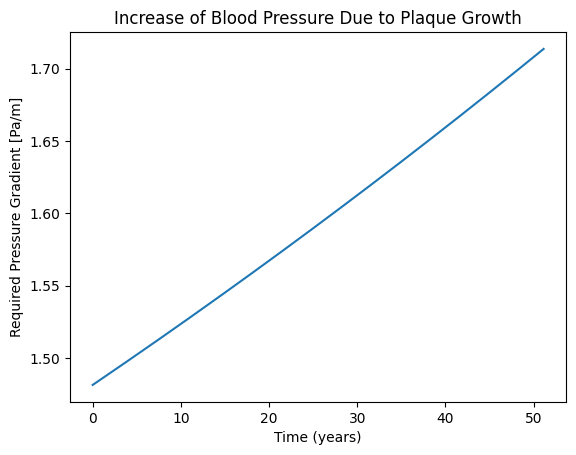

In [71]:
Ls = L - 2*h

def p(Ls, mu, Q):
    return 12*mu*Q/(Ls**4)

plt.figure()
plt.plot(times[::skip] / (3600 * 24 * 356), p(Ls, mu, Q_target)[:len(times[::skip])])
plt.xlabel("Time (years)")
plt.ylabel("Required Pressure Gradient [Pa/m]")
plt.title("Increase of Blood Pressure Due to Plaque Growth")
plt.show()